In [131]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd
from keras.models import load_model
import pickle
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [38]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=10, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [59]:
# Load training, validation and test sets
ds_train_ = image_dataset_from_directory(
    'train',
    validation_split=0.2,
    seed=123,
    subset="training",
    image_size=(224, 224),
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)
ds_val_ = image_dataset_from_directory(
    'train',
    validation_split=0.2,
    seed=123,
    subset="validation",
    image_size=(224, 224),
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)
ds_test_ = image_dataset_from_directory(
    'test',
    image_size=(224, 224),
    interpolation = 'nearest',
    labels='inferred',
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_val = (
    ds_val_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test = (
    ds_test_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [60]:
class_names = ds_train_.class_names
print('There are {} classes:'.format(len(class_names)))
for class_name in class_names:
    print('\t'+class_name)

Hay 7 clases:
	angry
	disgust
	fear
	happy
	neutral
	sad
	surprise


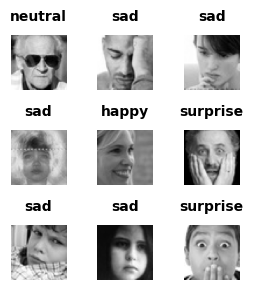

In [61]:
plt.figure(figsize=(3, 3))
for images, labels in ds_train_.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off");

In [64]:
# model = tf.keras.Sequential([
#                                 hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
#                                             trainable=False),
#                                 tf.keras.layers.Dense(len(class_names), activation='softmax')
#                             ])
# model.build([None, 224, 224, 3])
# model.summary()
# model.compile(
#     optimizer=Adam(lr=0.0001),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy'],
# )

# history = model.fit(
#     ds_train,
#     validation_data=ds_val,
#     epochs=30,
# )
# model.save('my_model.h5')
# with open('history.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_21 (KerasLayer)  (None, 1024)             1529968   
                                                                 
 dense_26 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 1,537,143
Trainable params: 7,175
Non-trainable params: 1,529,968
_________________________________________________________________
Epoch 1/30


2023-02-23 16:31:15.975612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


718/718 [==============================] - ETA: 0s - loss: 1.7111 - accuracy: 0.3215

2023-02-23 16:31:59.562938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


718/718 [==============================] - 62s 78ms/step - loss: 1.7111 - accuracy: 0.3215 - val_loss: 1.5986 - val_accuracy: 0.3888
Epoch 2/30
718/718 [==============================] - 49s 69ms/step - loss: 1.5526 - accuracy: 0.4020 - val_loss: 1.5240 - val_accuracy: 0.4208
Epoch 3/30
718/718 [==============================] - 48s 68ms/step - loss: 1.4943 - accuracy: 0.4308 - val_loss: 1.4845 - val_accuracy: 0.4372
Epoch 4/30
718/718 [==============================] - 49s 69ms/step - loss: 1.4573 - accuracy: 0.4451 - val_loss: 1.4583 - val_accuracy: 0.4463
Epoch 5/30
718/718 [==============================] - 49s 68ms/step - loss: 1.4301 - accuracy: 0.4562 - val_loss: 1.4391 - val_accuracy: 0.4541
Epoch 6/30
718/718 [==============================] - 49s 69ms/step - loss: 1.4088 - accuracy: 0.4653 - val_loss: 1.4242 - val_accuracy: 0.4597
Epoch 7/30
718/718 [==============================] - 50s 69ms/step - loss: 1.3915 - accuracy: 0.4718 - val_loss: 1.4123 - val_accuracy: 0.4637
Epo

In [69]:
model = load_model('my_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('history.pkl', 'rb') as f:
    history2 = pickle.load(f)

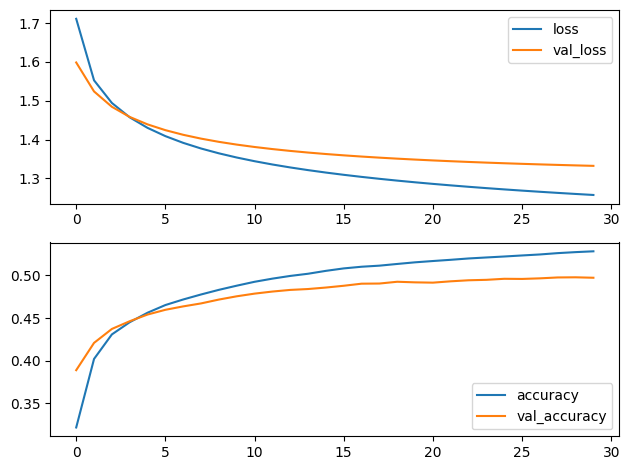

In [94]:
f,axes = plt.subplots(2)
history_frame = pd.DataFrame(history2)
history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1]);

In [141]:
x_train = np.concatenate([x for x, y in ds_train_], axis=0)
y_train = np.concatenate([y for x, y in ds_train_], axis=0)

x_val = np.concatenate([x for x, y in ds_val_], axis=0)
y_val = np.concatenate([y for x, y in ds_val_], axis=0)

y_test = np.concatenate([y for x, y in ds_test_], axis=0)
x_test = np.concatenate([x for x, y in ds_test_], axis=0)


'fear'

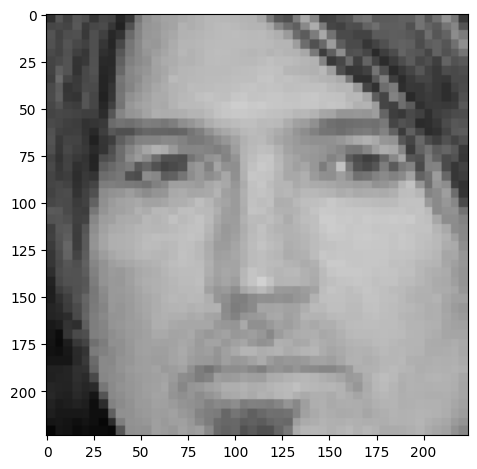

In [164]:
plt.imshow(x_train[0]);
class_names[y_train[0]]

In [156]:
y_train_predictions = np.argmax(model.predict(x_train),axis=1)
y_val_predictions = np.argmax(model.predict(x_val),axis=1)
y_test_predictions = np.argmax(model.predict(x_test),axis=1)

180/180 [==============================] - 11s 62ms/step


On train we get a 13.51% accuracy


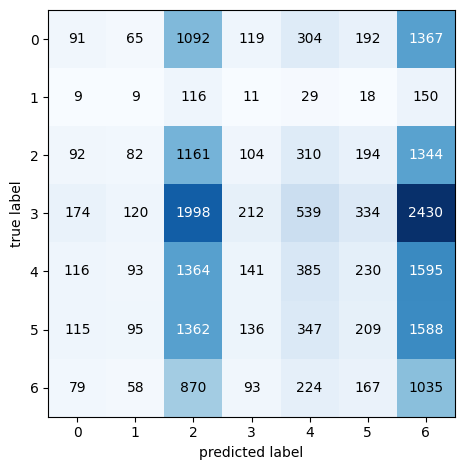

On validation we get a 13.64% accuracy


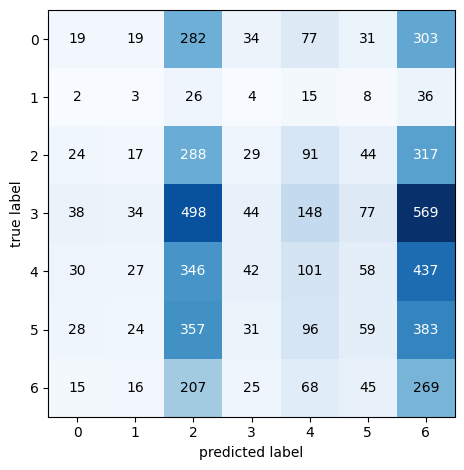

On test we get a 13.74% accuracy


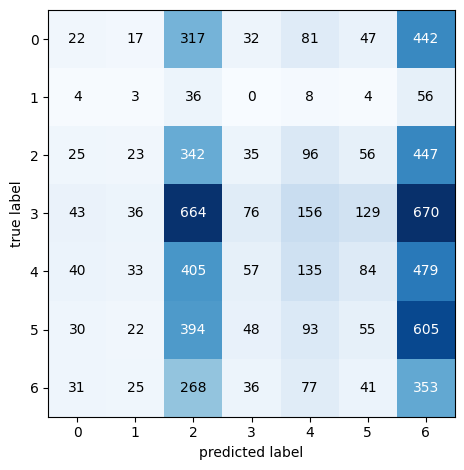

In [157]:
print("On train we get a {}% accuracy".format(round(100*accuracy_score(y_train, y_train_predictions),2)))
mat = confusion_matrix(y_train, y_train_predictions)
plot_confusion_matrix(mat);
plt.show()

print("On validation we get a {}% accuracy".format(round(100*accuracy_score(y_val, y_val_predictions),2)))
mat = confusion_matrix(y_val, y_val_predictions)
plot_confusion_matrix(mat);
plt.show()

print("On test we get a {}% accuracy".format(round(100*accuracy_score(y_test, y_test_predictions),2)))
mat = confusion_matrix(y_test,y_test_predictions)
plot_confusion_matrix(mat);
plt.show()